In [1]:
from ase.build import bulk, make_supercell
import numpy as np

from HopDec.ASE import *
from HopDec.Input import *
from HopDec.Lammps import *
from HopDec.State import *

import HopDec.Redecorate as Redecorate
import HopDec.Minimize as Minimize
import HopDec.NEB as NEB
import HopDec.MD as MD

%matplotlib inline
import matplotlib.pyplot as plt

# Generate Initial Structure (Vacancy in Pure Cu)

In [2]:
# Generate simple ASE structure

CuPrim = bulk('Cu', 'fcc', a=3.6, cubic=True)
CuPrim.cell
CuSuperCell = make_supercell(CuPrim, np.array([[5,0,0],[0,5,0],[0,0,5]]))

In [3]:
# Create Vacancy in supercell
del CuSuperCell[249]

In [4]:
CuSuperCell

Atoms(symbols='Cu499', pbc=True, cell=[18.0, 18.0, 18.0])

# Pass to Hop Dec

In [5]:
params = getParams()

In [6]:
# Initialize HopDec and transform ASE structure to State object

ase = ASE(params)
initialState = ase.toState(CuSuperCell)
initialState

In [7]:
# mininize State in-place

lmp = LammpsInterface(params)
Minimize.main(initialState, params, lmp = lmp, verbose = True)

[25/03/25, 09:02:41]:   Lammps >> Minimizing. F Tol: 1e-05.
[25/03/25, 09:02:41]: Lammps >> Completed Minimization, E: -1764.8919 eV


0.03035336407386224

# Find Transition

In [8]:
flag = 0
_, newState, flag = MD.main(initialState, params)

In [9]:
connection = NEB.main(initialState, newState, params, exportStructures = True, plotPathways = True, verbose = True) # run a NEB between these two states

[25/03/25, 09:02:43]: NEB >> Minimizing End Points
[25/03/25, 09:02:43]:   Lammps >> Minimizing. F Tol: 1e-05.
[25/03/25, 09:02:44]: Lammps >> Completed Minimization, E: -1764.8919 eV
[25/03/25, 09:02:44]:   Lammps >> Minimizing. F Tol: 1e-05.
[25/03/25, 09:02:44]: Lammps >> Completed Minimization, E: -1764.8919 eV
[25/03/25, 09:02:44]: NEB >> Initializing ASE Structure
[25/03/25, 09:02:44]: NEB >> Interpolating 11 images
[25/03/25, 09:02:44]: NEB >> Performing NEB. Force Tol: 0.1, Transition:
        ab2d71d992015e18300c2bc311585706 -> ab2d71d992015e18300c2bc311585706
[25/03/25, 09:02:44]: NEB >> NEB finished Successfully. Extracting Results
[25/03/25, 09:02:44]: NEB >> Checking NEB path for integrity
[25/03/25, 09:02:44]:   Lammps >> Minimizing. F Tol: 1e-05.
[25/03/25, 09:02:44]: Lammps >> Completed Minimization, E: -1764.8919 eV
[25/03/25, 09:02:44]:   Lammps >> Minimizing. F Tol: 1e-05.
[25/03/25, 09:02:44]: Lammps >> Completed Minimization, E: -1764.8919 eV
[25/03/25, 09:02:44]: 

In [10]:
connection.transitions[0].forwardBarrier

0.7327

# Redecorate Transition

In [11]:
# Given that we have found a valid Connection / Transition.
# We may want to run a redecoration campaign
# This one will take the States defined and conduct 10 NEBS (controlled in config file) 
# with redecoration of the atoms as either Cu or Ni at 50:50 concentrations (controlled in config file).
# Then return a results object
params.nDecorations = 2
redecResults = Redecorate.main(connection.transitions[0], params)

[25/03/25, 09:02:48]: Redecorate >> Starting NEB Redecoration Campaign
[25/03/25, 09:02:48]:   Redecorate >> rank: 0: Redecoration: 1
[25/03/25, 09:02:49]:   Redecorate >> rank: 0: Redecoration: 2


In [15]:
# The redecoration results contains 10 'Connection'.
# These 'connections' can be thought of as different decorations of the initial connection.
print(redecResults)
df = connection.transitions[0].loadRedecoration()
df

./eeab7a95621b6ee0a4e5192a14f18705_0485123e3e3ba4ba57f588443258c2aa


,Composition,Decoration,Transition,Initial State,Final State,Forward Barrier,Reverse Barrier,KRA,dE,Init Can Label,Init non-Can Label,Fin Can Label,Fin non-Can Label,Trans Can Label,Trans non-Can Label,Initial Energy,Final Energy
0,"0.5,0.5",1,1,<HopDec.State.State object at 0x17576c7d0>,<HopDec.State.State object at 0x1753344d0>,0.6816,0.7839,0.7328,-0.1023,b059c077aca75409f67425870a12869f,345fd5b75cdbe6264c5f4e618cbae5c9,6a695e4de455b1fbf52ee1c75788ee05,b2b6727a39b2b191fe3795252d096fc7,9a8682b1787178bd7deac11c50252c80,0485123e3e3ba4ba57f588443258c2aa,-1980.471855,-1980.574689
1,"0.5,0.5",2,1,<HopDec.State.State object at 0x16c3885c0>,<HopDec.State.State object at 0x175277f80>,0.9210,0.8580,0.8895,0.0630,55dde47b67b6c92c337dee649be5ca4c,345fd5b75cdbe6264c5f4e618cbae5c9,e0084b8210363ead6167031b2b9a936e,b2b6727a39b2b191fe3795252d096fc7,3d63bfacef7e8cd4ac33717fc41affe2,0485123e3e3ba4ba57f588443258c2aa,-1979.976632,-1979.914020


In [19]:
# the results object also contains the States of the redecorations
# In particular, this is the first redecoration and the first transition within that decoration.

df['Initial State']
df['Final State']

0    <HopDec.State.State object at 0x1753344d0>
1    <HopDec.State.State object at 0x175277f80>
Name: Final State, dtype: object

# Calculate Barrier as a Function of Cu:Ni Ratio

In [20]:
initialState.writeState('0.dat')
newState.writeState('1.dat')

In [21]:
params = getParams()
initialState = readStateLAMMPSData('0.dat')
finalState = readStateLAMMPSData('1.dat')

In [22]:
lmp = LammpsInterface(params)
minDistInit = lmp.minimize(initialState, verbose = True)
minDistFin = lmp.minimize(finalState, verbose = True)

[25/03/25, 09:04:57]:   Lammps >> Minimizing. F Tol: 1e-05.
[25/03/25, 09:04:57]: Lammps >> Completed Minimization, E: -1764.8919 eV
[25/03/25, 09:04:57]:   Lammps >> Minimizing. F Tol: 1e-05.
[25/03/25, 09:04:57]: Lammps >> Completed Minimization, E: -1764.8919 eV


In [24]:
# Cu_{x}Ni_{1-x}
xVals = [1,0.75,0.5,0.25,0]
results  = []

params.nDecorations = 10
params.activeSpecies = ['Cu','Ni']
params.staticSpecies = []

tempTransition = Transition(initialState, finalState)

for x in xVals:

    print(f'Cu: {x}, Ni: {1-x}')
    params.concentration = [x, 1-x]
    
    redFilename = Redecorate.main(tempTransition, params)
    df = tempTransition.loadRedecoration()

    results.append(np.mean( df['Forward Barrier'].to_list() ))

Cu: 1, Ni: 0
[25/03/25, 09:08:07]: Redecorate >> Starting NEB Redecoration Campaign
[25/03/25, 09:08:07]:   Redecorate >> rank: 0: Redecoration: 1
[25/03/25, 09:08:07]:   Redecorate >> rank: 0: Redecoration: 2
[25/03/25, 09:08:08]:   Redecorate >> rank: 0: Redecoration: 3
[25/03/25, 09:08:09]:   Redecorate >> rank: 0: Redecoration: 4
[25/03/25, 09:08:09]:   Redecorate >> rank: 0: Redecoration: 5
[25/03/25, 09:08:10]:   Redecorate >> rank: 0: Redecoration: 6
[25/03/25, 09:08:11]:   Redecorate >> rank: 0: Redecoration: 7
[25/03/25, 09:08:11]:   Redecorate >> rank: 0: Redecoration: 8
[25/03/25, 09:08:12]:   Redecorate >> rank: 0: Redecoration: 9
[25/03/25, 09:08:13]:   Redecorate >> rank: 0: Redecoration: 10
Cu: 0.75, Ni: 0.25
[25/03/25, 09:08:13]: Redecorate >> Starting NEB Redecoration Campaign
[25/03/25, 09:08:13]:   Redecorate >> rank: 0: Redecoration: 1
[25/03/25, 09:08:14]:   Redecorate >> rank: 0: Redecoration: 2
[25/03/25, 09:08:15]:   Redecorate >> rank: 0: Redecoration: 3
[25/03

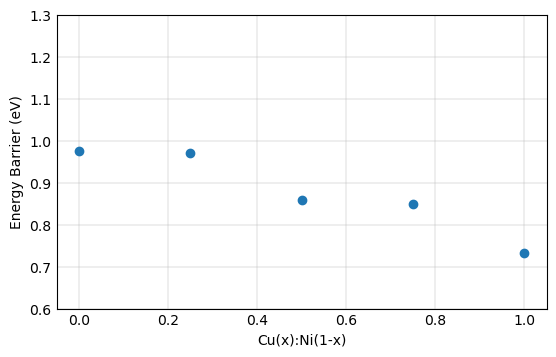

In [25]:
fig, axs = plt.subplots(1,1, figsize = (5,3))

axs.scatter(xVals, results)
axs.set_xlabel('Cu(x):Ni(1-x)')
axs.set_ylabel('Energy Barrier (eV)')
axs.set_ylim([0.6,1.3])

axs.grid(True, linewidth=0.3)